# Multi-Class Image for American Sign Language 🤙
## 1. Problem

identifying the image of American sign language.

## 2. Data

the data we're using is from kaggle's ASL_Alphabet_Dataset.

https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset

## 3. Evaluation

....fill it latter

## 4. Features

....fill it latter

In [ ]:
# Unzip the uploaded data into google drive
#!unzip -u 'drive/MyDrive/dataset/sign_language_dataset.zip' -d 'drive/MyDrive/dataset/'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Get our workspace ready

* importing TensorFlow 2.x ✅
* importing TensorFlow hub ✅
* make sure we're using GPU ✅

## Importing the Library 📚

In [2]:
# Importing the TensorFlow into Colab
# importing necessary tools
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import datetime
import glob
import seaborn as sns
#import IPython
#!pip install -U Ipython
import tf_keras as tfk
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.layers import Dense
from keras._tf_keras.keras.models import Sequential, Model
from keras._tf_keras.keras.callbacks import Callback, EarlyStopping

In [3]:
# check for library version
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.17.0
Hub version: 0.16.1
GPU available


## Loading the data

In [ ]:
path_train = 'drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train'
path_test = '/content/drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_test'

In [ ]:
# take all images from folders
train_path_list = list(glob.glob(path_train+'/**/*.jpg'))
test_path_list = list(glob.glob(path_test+'/*.jpg'))

In [ ]:
def prepare_data_labels_and_paths(file_path):
    """
    Prepares a DataFrame containing image file paths and their corresponding labels.
    Args:
        file_path (list[str]): A list of file paths to the image files.

    Returns:
        pandas.DataFrame: A DataFrame with two columns: 'FilePath' containing the file paths and 'Label' containing the corresponding labels.

    Raises:
        ValueError: If the input `file_path` is not a list of strings.

    Example:
        ```python
        import os

        file_path = [
            "path/to/image1.jpg",
            "path/to/image2.jpg",
            "path/to/image3.jpg"
        ]

        df = prepare_data_labels_and_paths(file_path)
        print(df)
        ```
    """
    if not isinstance(file_path, list) or not all(isinstance(path, str) for path in file_path):
        raise ValueError("`file_path` must be a list of strings.")
    labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1].lower(), file_path))
    filepath = pd.Series(file_path, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [ ]:
data_for_training = prepare_data_labels_and_paths(train_path_list)
data_for_training.head()

,FilePath,Label
0,drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl...,w
1,drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl...,m
2,drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl...,j
3,drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl...,a
4,drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl...,b


In [ ]:
data_for_training.to_csv('/content/drive/MyDrive/dataset/ASL_Alphabet_Dataset/sign_data_for_training.csv',
                                index=False)

In [4]:
data_for_training = pd.read_csv('/content/drive/MyDrive/dataset/ASL_Alphabet_Dataset/sign_data_for_training.csv')

In [5]:
len(data_for_training)

217522

In [12]:
# Find the unique label values
unique_sign = np.unique(data_for_training['Label'])
len(unique_sign),unique_sign

(29,
 array(['a', 'b', 'c', 'd', 'del', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
        'm', 'n', 'nothing', 'o', 'p', 'q', 'r', 's', 'space', 't', 'u',
        'v', 'w', 'x', 'y', 'z'], dtype=object))

## Visualizing our Data 📊

In [ ]:
def display_images_in_subplots(data, nrows=3, ncols=4, figsize=(10, 7)):
  """
  Displays a grid of images from the provided data in Matplotlib subplots.

  Args:
      data (pandas.DataFrame or similar): A DataFrame-like object containing two columns:
          - 'FilePath': A list of file paths to the images to be displayed.
          - 'Label': A list of labels for each image (optional).
      nrows (int, optional): The number of rows in the subplot grid. Defaults to 3.
      ncols (int, optional): The number of columns in the subplot grid. Defaults to 4.
      figsize (tuple, optional): The width and height of the figure in inches. Defaults to (10, 7).

  Raises:
      ValueError: If the data object does not have 'FilePath' and 'Label' columns (if labels are provided).
      IndexError: If the number of images in 'FilePath' exceeds the available subplots.
  """

  # Check for required columns
  if not all(col in data.columns for col in ['FilePath']):
    raise ValueError("Data must contain a 'FilePath' column.")

  # Check if labels are provided and their length matches image count
  if 'Label' in data.columns and len(data.Label) != len(data.FilePath):
    raise ValueError("'Label' column length must match the number of images.")

  num_images = len(data.FilePath)

  # Ensure nrows and ncols are sufficient
  if num_images > nrows * ncols:
    raise IndexError(f"Not enough subplots to display all images ({num_images}).")

  fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'xticks': [], 'yticks': []})

  axes_flat = axes.flat  # Flatten the axes for iteration

  # Iterate through images and display them
  for i, (filepath, label) in enumerate(zip(data.FilePath, data.get('Label', [''] * num_images))):
    ax = axes_flat[i]
    ax.imshow(plt.imread(filepath))
    if label:
      ax.set_title(label)

  plt.tight_layout()
  plt.show()

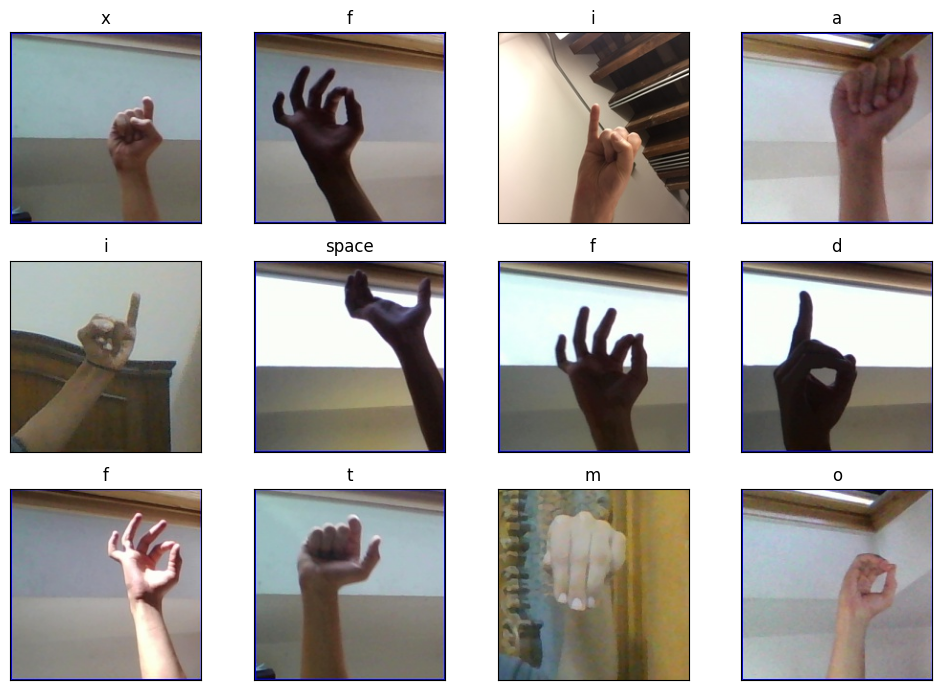

In [ ]:
display_images_in_subplots(data=data_for_training[:12])

In [6]:
def plot_label_counts(data):
    """
    Plots the counts of each unique label in a given dataset.

    Args:
        data (pandas.DataFrame): The input dataset.

    Returns:
        None
    """

    plt.figure(figsize=(12, 6))
    counts = data.Label.value_counts()

    # Choose a more subdued color palette
    colors = sns.color_palette("flare", len(counts))

    sns.barplot(x=counts.index, y=counts, palette=colors)

    # Add a grid for better readability
    plt.grid(axis='y', linestyle='--')

    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=50)

In [ ]:
import hashlib

image_hashes = {}
for image_file in data_for_training.FilePath:
    with open(image_file, 'rb') as f:
        hash_value = hashlib.sha256(f.read()).hexdigest()
        if hash_value in image_hashes:
            print("Duplicate image:", image_file)
        else:
            image_hashes[hash_value] = image_file

Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/J/J (2053).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/del/del (3432) (1).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/I/I (3449).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/R/R (1107).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/D/D471.jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/del/del1545.jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/D/D (2537).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space1698.jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/M/M (2921).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/F/F (3056).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabe

KeyboardInterrupt: 

<ipython-input-6-3a7169fa48b3>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette=colors)


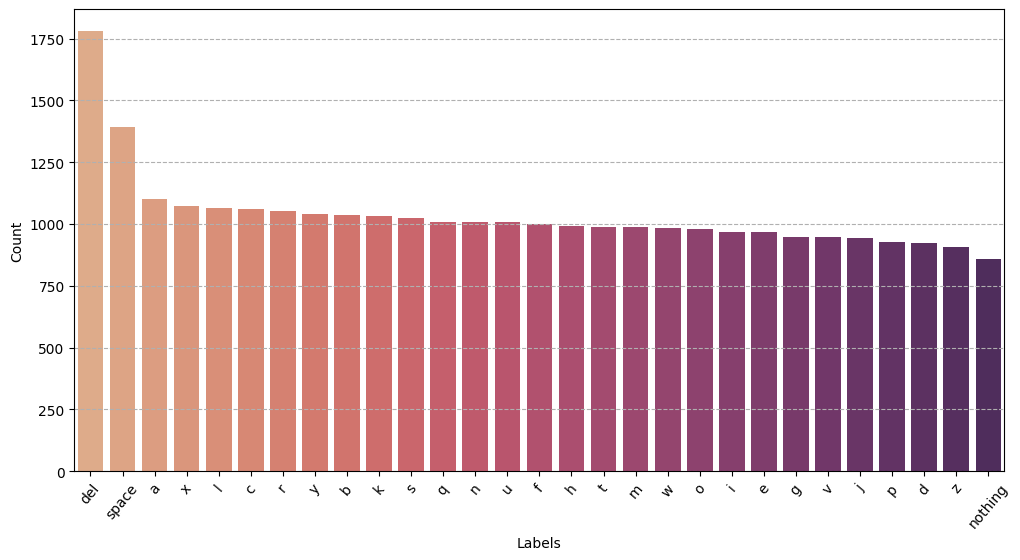

In [36]:
plot_label_counts(data_for_training[:30000])

## Creating our own Training & Validation Sets 📁

In [6]:
train_df, test_df = train_test_split(data_for_training[:30000], train_size=0.9, random_state=1)

## Preprocessing Data

In [7]:
# def Generates_training_validation_test_data(pre, train, test):
#     """
#     Generates training, validation, and test data generators from Pandas DataFrames.

#     Args:
#         pre: A preprocessing function to apply to the images.
#         train: A Pandas DataFrame containing the training data.
#         test: A Pandas DataFrame containing the testing data.

#     Returns:
#         A tuple of training, validation, and test generators.
#     """
#     # Create ImageDataGenerators with the specified preprocessing function
#     train_datagen = ImageDataGenerator(
#         preprocessing_function=pre,
#         validation_split=0.2
#     )
#     test_datagen = ImageDataGenerator(
#         preprocessing_function=pre

#     )

#     # Generate training, validation, and test data from dataframes
#     train_gen = train_datagen.flow_from_dataframe(
#         dataframe=train,
#         x_col='FilePath',
#         y_col='Label',
#         target_size=(224, 224),
#         class_mode='categorical',
#         batch_size=32,
#         shuffle=True,
#         seed=0,
#         subset='training',
#         rotation_range=30,
#         zoom_range=0.15,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.15,
#         horizontal_flip=True,

#         fill_mode="nearest"

#     )
#     valid_gen = train_datagen.flow_from_dataframe(
#         dataframe=train,
#         x_col='FilePath',
#         y_col='Label',
#         target_size=(224, 224),
#         class_mode='categorical',
#         batch_size=32,
#         shuffle=False,

#         seed=0,
#         subset='validation',
#         rotation_range=30,
#         zoom_range=0.15,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.15,
#         horizontal_flip=True,

#         fill_mode="nearest"
#     )
#     test_gen = test_datagen.flow_from_dataframe(
#         dataframe=test,
#         x_col='FilePath',
#         y_col='Label',
#         target_size=(224, 224),
#         color_mode='rgb',
#         class_mode='categorical',
#         batch_size=32,
#         shuffle=False
#     )

#     return train_gen, valid_gen, test_gen

In [30]:
def preprocess_images_with_datagen_train(df, target_size=(224, 224)):
  """
  Preprocesses images in a DataFrame using ImageDataGenerator without augmentation.

  Args:
    df: DataFrame containing 'FilePath' and 'Label' columns.
    target_size: Tuple specifying the desired width and height of the images.

  Returns:
    A generator that yields batches of preprocessed images and labels.
  """

  # Create an ImageDataGenerator instance without augmentation
  datagen = ImageDataGenerator( rescale=1./255,
                                # rotation_range=40,
                                # height_shift_range=0.2,
                                # width_shift_range=0.2,
                                # shear_range=0.2,
                                # zoom_range=0.2,
                                # horizontal_flip=True,
                                # fill_mode='nearest',
                                )  # Rescale pixel values to 0-1

  # Create a generator from the DataFrame
  train_generator = datagen.flow_from_dataframe(
      dataframe=df,
      x_col='FilePath',
      y_col='Label',
      target_size=target_size,
      batch_size=32,  # Adjust batch size as needed
      class_mode='categorical'  # Adjust class mode if necessary
  )



  return train_generator

In [31]:
def preprocess_images_with_datagen(df, target_size=(224, 224)):
  """
  Preprocesses images in a DataFrame using ImageDataGenerator without augmentation.

  Args:
    df: DataFrame containing 'FilePath' and 'Label' columns.
    target_size: Tuple specifying the desired width and height of the images.

  Returns:
    A generator that yields batches of preprocessed images and labels.
  """

  # Create an ImageDataGenerator instance without augmentation
  datagen = ImageDataGenerator( rescale=1./255,)  # Rescale pixel values to 0-1

  # Create a generator from the DataFrame
  generator = datagen.flow_from_dataframe(
      dataframe=df,
      x_col='FilePath',
      y_col='Label',
      target_size=target_size,
      batch_size=32,  # Adjust batch size as needed
      class_mode='categorical'  # Adjust class mode if necessary
  )

  return generator

Comparison to tf.keras.preprocessing.image.ImageDataGenerator

The `preprocess_image` function is similar to the data generation process in `tf.keras.preprocessing.image.ImageDataGenerator`. However, there are some key differences:

* Single Image Processing: The preprocess_image function processes a single image at a time, while ImageDataGenerator can process multiple images in batches.
* Data Augmentation: ImageDataGenerator can apply various data augmentation techniques (e.g., rotation, flipping, zooming) to increase the diversity of the training data.
* Flowing Data: ImageDataGenerator can generate a flow of preprocessed images, which is often convenient for training models.


If you need to process multiple images or apply data augmentation, `ImageDataGenerator` would be a more suitable choice. However, for simple preprocessing tasks on individual images, the `preprocess_image` function provides a concise and efficient solution.

In [11]:
def preprocess_image(image_path, target_size=(224, 224)):
  """
  Preprocesses an image by reading it from a file, converting it to a tensor,
  normalizing it, resizing it, and optionally applying data augmentation techniques.

  Args:
      image_path (str): The path to the image file.
      target_size (tuple, optional): The desired size of the image (width, height).
          Defaults to (224, 224).
      data_augmentation (bool, optional): Whether to apply data augmentation
          techniques. Defaults to False.
          If True, consider using libraries like Albumentations for more
          flexibility, or create your own augmentation functions.

  Returns:
      tf.Tensor: The preprocessed image tensor.
  """

  # Read the image file and convert it to a tensor
  image = tf.io.read_file(image_path)

  # Decode the image based on its format (e.g., JPEG, PNG)
  image = tf.image.decode_image(image, channels=3)  # Assuming RGB

  # Normalize the image to the range [0, 1]
  image = tf.cast(image, tf.float32) / 255.0

  # Resize the image to the target size
  image = tf.image.resize(image, target_size)

  # Optionally apply data augmentation techniques
  #if data_augmentation:
      # Consider using libraries like Albumentations for flexibility
      # or create your own augmentation functions here

  return image

## Modeling

In [35]:
IMG_SIZE = 224

In [36]:
 # setup input shape to the model
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]
 # setup the output shape of our model
OUTPUT_SHAPE = len(unique_sign)

 # setup model url from tensorflow hub
MODEL_URL ={'mobilenet':"https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-feature-vector/4",
            'resnet_50':"https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"}

In [37]:
def create_custom_model(name_model):
    """
    Creates a custom image classification model based on a pre-trained model.

    Args:
        name_model: A function or class representing a pre-trained model.

    Returns:
        A tuple containing the compiled model and a list of callbacks.
    """

    pre_model = name_model(input_shape=(224,224, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(120, activation='relu')(pre_model.output)
    x = Dense(120, activation='relu')(x)
    outputs = Dense(len(unique_sign), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              mode='auto')]
    return model, my_callbacks

## Evaluating

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_and_evaluate(history, test_gen, train_gen, model, test_df):
    """
    Plots training and validation performance metrics and evaluates the model on test data.

    Args:
        history (History object): Training history object from model.fit().
        test_gen (ImageGenerator): Test data generator.
        train_gen (ImageGenerator): Training data generator.
        model (Model): Compiled Keras model.
        test_df (pandas.DataFrame): Test dataframe containing 'FilePath' and 'Label' columns.

    Returns:
        None
    """

    # Plot training and validation accuracy/loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Val'])
    plt.tight_layout()

    # Make predictions on test data
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)  # Get class indices

    # Convert class indices to labels using training generator's class_indices
    class_labels = dict((v, k) for k, v in train_gen.class_indices.items())
    predicted_labels = [class_labels[k] for k in predicted_classes]

    # Print classification report
    print("Classification Report:")
    print(classification_report(test_df['Label'], predicted_labels))

    # Create confusion matrix
    confusion_matrix_ = confusion_matrix(test_df['Label'], predicted_labels)
    print("\nConfusion Matrix:")
    print(confusion_matrix_)

    # Display 6 pictures with their true and predicted labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        image = plt.imread(test_df.FilePath.iloc[i + 1])
        ax.imshow(image)
        ax.set_title(f"True: {test_df.Label.iloc[i + 1]}\nPredicted: {predicted_labels[i + 1]}")
    plt.tight_layout()
    plt.show()

In [16]:
def result_test(test, model_use):
  """
  Evaluates a model on a test dataset.

  Args:
    test: A test data generator.
    model_use: The compiled Keras model.

  Returns:
    A tuple containing the test loss and accuracy.
  """

  results = model_use.evaluate(test, verbose=0)

  print("    Test Loss: {:.5f}".format(results[0]))
  print("Test Accuracy: {:.2f}%".format(results[1] * 100))

  return results

## Saving a model

In [17]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/MyDrive/Colab Notebooks/American_Sign_Language/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

## Try and Fit Pretrained models

### ResNet

#### ResNet50

In [ ]:
from keras._tf_keras.keras.applications.resnet import ResNet50
from keras._tf_keras.keras.applications.resnet50 import preprocess_input
RestNet50_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = Generates_training_validation_test_data(RestNet50_pre,train_df, test_df)

Found 560 validated image filenames belonging to 29 classes.
Found 140 validated image filenames belonging to 29 classes.
Found 300 validated image filenames belonging to 29 classes.


In [ ]:
ResNet50_model, callback=create_custom_model(ResNet50)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
valid_gen_RestNet

In [ ]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=50,
    callbacks=callback
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 354s 13s/step - accuracy: 0.0948 - loss: 3.4275 - val_accuracy: 0.1286 - val_loss: 3.0289
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.3738 - loss: 2.4107 - val_accuracy: 0.2714 - val_loss: 2.5280
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.5384 - loss: 1.7533 - val_accuracy: 0.3929 - val_loss: 2.1709
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.6927 - loss: 1.1999 - val_accuracy: 0.5643 - val_loss: 1.6462
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.7882 - loss: 0.8196 - val_accuracy: 0.5571 - val_loss: 1.5858
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.8963 - loss: 0.5322 - val_accuracy: 0.6429 - val_loss: 1.4423
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.9328 - loss: 0.3729 - val_accuracy: 0.6500 - val_loss: 1.3353
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.9540 - loss: 0.2806 - val_accuracy: 0.6500 - val

In [ ]:
# Save our model trained on 1000 images
save_model(ResNet50_model, suffix="sign-language-resnet-Adam")

Saving model to: drive/MyDrive/Colab Notebooks/American_Sign_Language/models/20241016-21171729113432-sign-language-resnet-Adam.h5...


'drive/MyDrive/Colab Notebooks/American_Sign_Language/models/20241016-21171729113432-sign-language-resnet-Adam.h5'

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 497ms/step
Classification Report:
              precision    recall  f1-score   support

           a       0.64      0.75      0.69        12
           b       0.86      0.50      0.63        12
           c       0.71      0.83      0.77        12
           d       0.75      0.82      0.78        11
         del       0.95      0.90      0.92        20
           e       1.00      0.44      0.62         9
           f       0.86      0.75      0.80         8
           g       0.56      0.62      0.59         8
           h       0.67      0.60      0.63        10
           i       0.71      0.56      0.62         9
           j       1.00      0.78      0.88         9
           k       0.92      0.86      0.89        14
           l       1.00      0.67      0.80         9
           m       0.50      0.83      0.62         6
           n       0.67      0.80      0.73        10
     nothing       1.00      1.00      1.00        10
           o     

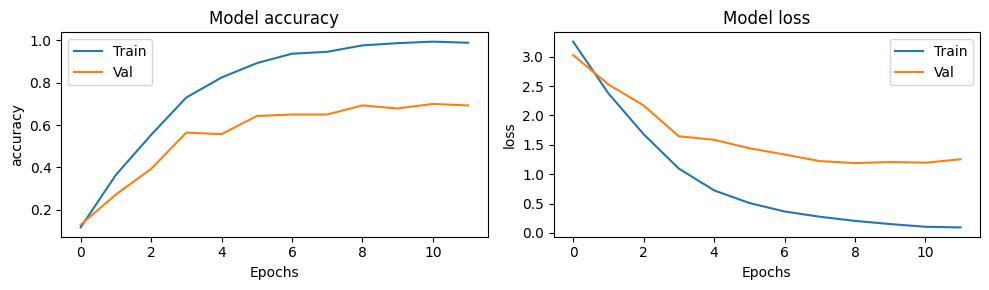

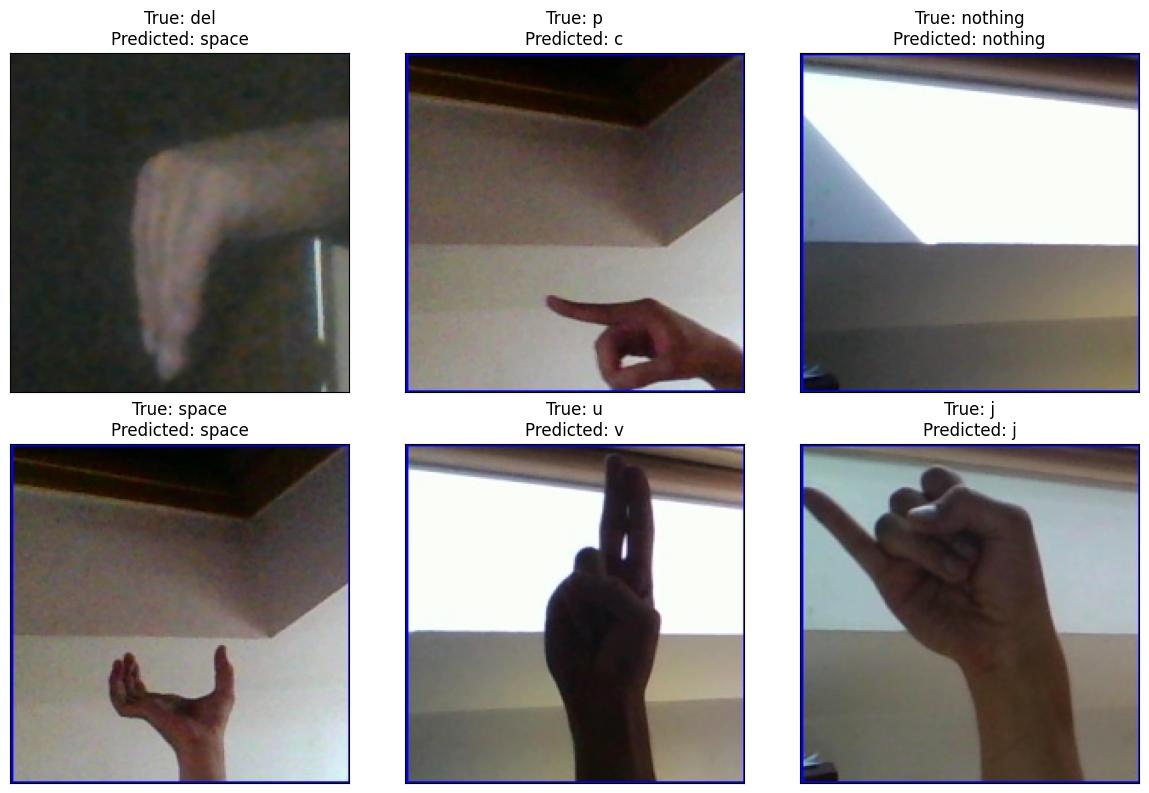

In [ ]:
history_ResNet=plot_and_evaluate(history,test_gen_RestNet,train_gen_RestNet,ResNet50_model,test_df)

In [ ]:
result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

    Test Loss: 1.09796
Test Accuracy: 70.00%


### MobileNet

In [18]:

from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = Generates_training_validation_test_data(MobileNet_pre,train_df, test_df)

KeyboardInterrupt: 

In [32]:
train_gen_MobileNet = preprocess_images_with_datagen_train(train_df[:int(len(train_df)-len(train_df)*0.2)])

Found 21600 validated image filenames belonging to 29 classes.


In [33]:
valid_gen_MobileNet = preprocess_images_with_datagen_train(train_df[int(len(train_df)-len(train_df)*0.2):])

Found 5400 validated image filenames belonging to 29 classes.


In [34]:
test_gen_MobileNet = preprocess_images_with_datagen(test_df)

Found 3000 validated image filenames belonging to 29 classes.


In [38]:
from tensorflow.keras.applications import MobileNet
MobileNet_model, callback=create_custom_model(MobileNet)

In [ ]:
history_MobileNet = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/675 ━━━━━━━━━━━━━━━━━━━━ 3:21:24 23s/step - accuracy: 0.3354 - loss: 2.4403

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Classification Report:
              precision    recall  f1-score   support

           a       0.69      0.75      0.72        12
           b       0.80      0.67      0.73        12
           c       0.86      1.00      0.92        12
           d       1.00      0.91      0.95        11
         del       1.00      1.00      1.00        20
           e       0.80      0.89      0.84         9
           f       0.50      0.75      0.60         8
           g       0.55      0.75      0.63         8
           h       1.00      0.50      0.67        10
           i       0.71      0.56      0.62         9
           j       0.67      0.89      0.76         9
           k       0.86      0.86      0.86        14
           l       1.00      1.00      1.00         9
           m       0.75      1.00      0.86         6
           n       1.00      0.80      0.89        10
     nothing       1.00      0.90      0.95        10
           o       

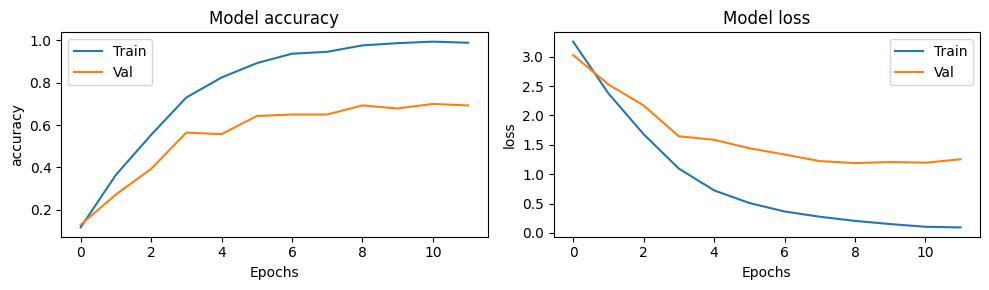

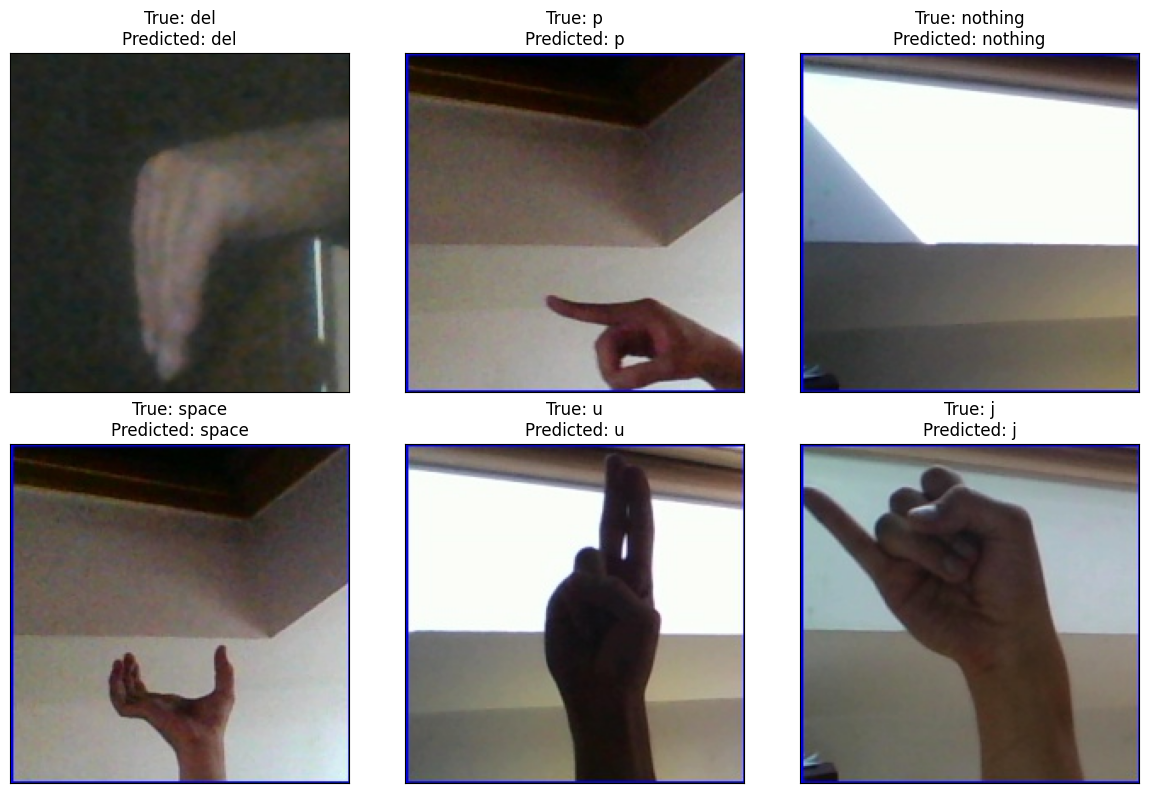

In [ ]:
# this with 1000 image
history=plot_and_evaluate(history,test_gen_MobileNet,train_gen_MobileNet,MobileNet_model,test_df)

In [ ]:
# this with 1000 image
result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

    Test Loss: 0.69486
Test Accuracy: 81.00%


In [22]:
# this with 1000 image
# Save our model trained on 1000 images
save_model(ResNet50_model, suffix="sign-language-30000-data-mobilenet-Adam")

NameError: name 'ResNet50_model' is not defined

In [ ]:
history=plot_and_evaluate(history,test_gen_MobileNet,train_gen_MobileNet,MobileNet_model,test_df)

## CNN Model

In [ ]:
def preprocess_images_with_datagen(df, target_size=(224, 224)):
  """
  Preprocesses images in a DataFrame using ImageDataGenerator without augmentation.

  Args:
    df: DataFrame containing 'FilePath' and 'Label' columns.
    target_size: Tuple specifying the desired width and height of the images.

  Returns:
    A generator that yields batches of preprocessed images and labels.
  """

  # Create an ImageDataGenerator instance without augmentation
  datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to 0-1

  # Create a generator from the DataFrame
  generator = datagen.flow_from_dataframe(
      dataframe=df,
      x_col='FilePath',
      y_col='Label',
      target_size=target_size,
      batch_size=32,  # Adjust batch size as needed
      class_mode='categorical'  # Adjust class mode if necessary
  )

  return generator

In [ ]:
train_generator = preprocess_images_with_datagen(train_df)
validation_generator = preprocess_images_with_datagen(test_df)

KeyboardInterrupt: 

In [ ]:
def create_cnn_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    """Creates a CNN model for multi-class image classification.

    Args:
        input_shape: The shape of the input images (height, width, channels).
        output_shape: The number of output classes.

    Returns:
        A compiled CNN model.
    """

    cnn = tfk.models.Sequential()

    # Add convolutional layers with batch normalization and pooling
    cnn.add(tfk.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    cnn.add(tfk.layers.BatchNormalization())
    cnn.add(tfk.layers.MaxPool2D(pool_size=2, strides=2))

    cnn.add(tfk.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(tfk.layers.BatchNormalization())
    cnn.add(tfk.layers.MaxPool2D(pool_size=2, strides=2))

    cnn.add(tfk.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(tfk.layers.BatchNormalization())
    cnn.add(tfk.layers.MaxPool2D(pool_size=2, strides=2))

    # Flatten the output
    cnn.add(tfk.layers.Flatten())

    # Add dense layers
    cnn.add(tfk.layers.Dense(units=128, activation='relu'))

    # Add output layer
    cnn.add(tfk.layers.Dense(units=output_shape, activation='softmax'))

    cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    my_callbacks  = [tfk.callbacks.EarlyStopping(monitor='val_loss',
                              patience=3,
                              )]


    return cnn,my_callbacks

In [ ]:
NUM_EPOCHS=50

In [ ]:
# build a function to train and return a trained model
def train_model(model,callback,train_data,val_data):
  """
  Training a given model and returns the trained version.
  """

  # Fit the model to the data passing it the callbacks we created
  histoy=model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            callbacks=callback,
            batch_size=32)
  # Return the model to the data
  return histoy

In [ ]:
cnn_model , callback_cnn =create_cnn_model()

In [ ]:
history_cnn = train_model(cnn_model,callback_cnn,train_generator,validation_generator)